## KR260 HLS Configurable Fixed Gain with AXI Streaming Interface
This tutorial demonstrates how to accelerate a Python function on the KR260 using PYNQ, and how to interface with a Vitis HLS modules which has a AXI Streaming interface with an AXI Lite interface for Status/Control

### Plot function for use in this notebook
The first code block below defines a function that we will use for plotting data throughout this notebook. Note that the function has a `n_samples` argument so that we can limit the number of samples to plot. Plotting more than a few thousand samples can be very slow and consume a lot of RAM.

### Requirements
Install the following:

pip install ipympl

pip install ipywidgets


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='Gain output')
    plt.legend()

### Generate the input signal

Number of samples:  2000000


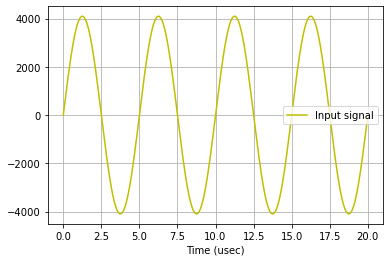

In [2]:
import numpy as np
# Amp
AMP = 4096
# Total time
T = 0.02
# Sampling frequency
fs = 100e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signal
samples = 4096*np.sin(0.2e6*2*np.pi*t) # + 1500*np.cos(46e6*2*np.pi*t) + 2000*np.sin(12e6*2*np.pi*t)
# Convert samples to 32-bit integers
samples = samples.astype(np.int32)
print('Number of samples: ',len(samples))

# Plot signal to the notebook
plot_to_notebook(t,samples,2000)

### Hardware HLS Gain Block Implementation
##### Load Overlay

In [3]:
from pynq import Overlay
from pynq import allocate
import pynq.lib.dma
import time
import led_reg

# Load the overlay
overlay = Overlay('/home/root/jupyter_notebooks/kr260_hls_fixed_gain_stream/kr260_hls_fixed_gain_stream.bit')

# Assign blocks to short vars
dma       = overlay.axi_dma_0
gain_reg  = overlay.axi_fixed_gain_stream_0
led_module= overlay.led_reg_0

##### Print out the register map for DMA and HLS Gain Blocks

In [5]:
overlay.ip_dict

{'axi_dma_0': {'type': 'xilinx.com:ip:axi_dma:7.1',
  'mem_id': 'S_AXI_LITE',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_LITE_ADDR_WIDTH': '10',
   'C_S_AXI_LITE_DATA_WIDTH': '32',
   'C_DLYTMR_RESOLUTION': '125',
   'C_PRMRY_IS_ACLK_ASYNC': '0',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_NUM_MM2S_CHANNELS': '1',
   'C_NUM_S2MM_CHANNELS': '1',
   'C_INCLUDE_SG': '0',
   'C_SG_INCLUDE_STSCNTRL_STRM': '0',
   'C_SG_USE_STSAPP_LENGTH': '0',
   'C_SG_LENGTH_WIDTH': '23',
   'C_M_AXI_SG_ADDR_WIDTH': '32',
   'C_M_AXI_SG_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_S_AXIS_S2MM_STS_TDATA_WIDTH': '32',
   'C_MICRO_DMA': '0',
   'C_INCLUDE_MM2S': '1',
   'C_INCLUDE_MM2S_SF': '1',
   'C_MM2S_BURST_SIZE': '16',
   'C_M_AXI_MM2S_ADDR_WIDTH': '32',
   'C_M_AXI_MM2S_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '32',
   'C_INCLUDE_MM2S_DRE': '0',
   'C_INCLUDE_S2MM': '1',
   'C_INCLUDE_S2MM_SF': '1',
   'C_S2MM_BURST_SIZE': '16',
  

In [6]:
print('led_reg_0.phys_addr: ', hex(2684485632))
print('led_reg_0.addr_range: ', hex(65536))


led_reg_0.phys_addr:  0xa0020000
led_reg_0.addr_range:  0x10000


In [7]:
IP_BASE_ADDRESS = 0xa0020000
ADDRESS_RANGE = 0x1000
ADDRESS_OFFSET = 0x10

from pynq import MMIO
mmio = MMIO(IP_BASE_ADDRESS, ADDRESS_RANGE)

In [9]:
print('Writing Register...')
mmio.write(ADDRESS_OFFSET, 0x0)
print('Reading Register...')
result = mmio.read(ADDRESS_OFFSET)
print('done.')

Writing Register...
Reading Register...
done.


In [ ]:
dma.register_map

In [ ]:
gain_reg.register_map

##### Configure the GAIN register Control Register
Want to enable auto restart, so the FPGA block will always be read to receive samples

In [4]:
gain_reg.register_map.CTRL.AUTO_RESTART=1
gain_reg.register_map.CTRL.AP_START=1
gain_reg.register_map.CTRL

Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0)

##### Toggle USER_LED[1:0] on/off

In [5]:
for i in range(10):
    led_reg.register_map.GPIO_DATA=0x1
    time.sleep(1)
    led_reg.register_map.GPIO_DATA=0x2
    time.sleep(1)
led_reg.register_map.GPIO_DATA=0x0

##### Configure the GAIN register Value Register

In [6]:
gain_reg.write(gain_reg.register_map.gain.address,5)
print("Gain Register : " + str(gain_reg.read(gain_reg.register_map.gain.address)))

Gain Register : 5


### DMA Transfer the Sinewave buffer from ARM Processor to the FPGA HLS Gain Block, and plot

Gain Register                : 5
DMA Transfer Size            : 2000000
DMA Transfer Execution Time  : 0.061692237854003906  sec


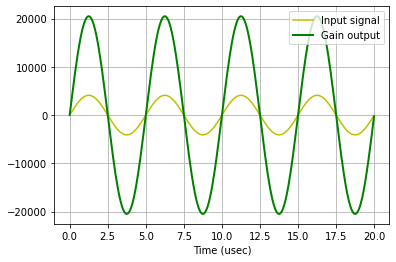

In [7]:
# Read Gain Register
print("Gain Register                : " + str(gain_reg.read(gain_reg.register_map.gain.address)))

print("DMA Transfer Size            : " + str(len(samples)))

# Allocate buffers for the input and output signals
in_buffer = allocate(shape=(len(samples),), dtype=np.int32)
out_buffer = allocate(shape=(len(samples),), dtype=np.int32)

# Copy the samples to the in_buffer
np.copyto(in_buffer,samples)

# Trigger the DMA transfer and wait for the result
import time
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
#print('Submit sending the transfer into in_buffer')
dma.recvchannel.transfer(out_buffer)
#print('Submit receiving the transfer from out_buffer')
dma.sendchannel.wait()
#print('Done Sending the transfer to in_buffer')
dma.recvchannel.wait()
#print('Done receiving the transfer from out_buffer')
stop_time = time.time()
hw_exec_time = stop_time-start_time

print('DMA Transfer Execution Time  :',hw_exec_time,' sec')

# Plot to the notebook
plot_to_notebook(t,samples,2000,out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close()

In [ ]:
del in_buffer, out_buffer